# Generating data with the prior/posterior distribution

Visualizing the distribution of the prior can help to manually choose a better prior (being completely uninformative is just useless). Also, visualizing the posterior distribution allows to verify if the posterior is correct or completely wrong.

Here, we will take as a model:

$T(n) = \alpha + n\times\beta |\mathcal{N}(0, \sigma^2)|$

In [1]:
import pandas
from plotnine import *
import warnings
import pystan
import matplotlib.pyplot as plt
import numpy
import statsmodels.formula.api as st
warnings.simplefilter(action='ignore', category=FutureWarning)

def generate_dataset(alpha, beta, sigma, N=1000, min_x=0, max_x=10000):
    numpy.random.seed(42)
    noise = numpy.abs(numpy.random.normal(0, sigma, N))
    size = numpy.random.randint(min_x, max_x, N)
    duration = alpha + size * (noise + beta)
    df = pandas.DataFrame(dict(size=size, duration=duration))
    return df

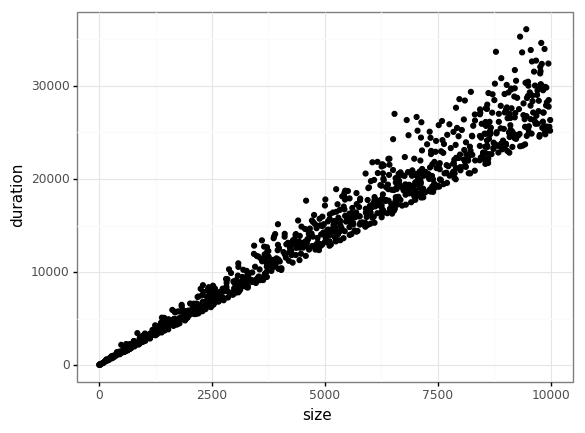

<ggplot: (8775739131663)>

In [2]:
df = generate_dataset(30, 2.5, 0.5)
plot = ggplot(df, aes(x='size', y='duration')) + geom_point() + expand_limits(y=1) + theme_bw()
plot

## Naive approach

In [3]:
def compute_params_naive(df, quantile=0.01):
    small_sizes = df[df['size'] < df['size'].quantile(quantile)]
    large_sizes = df[df['size'] > df['size'].quantile(1-quantile)].copy()
    intercept = small_sizes['size'].mean()
    large_sizes['size'] -= intercept
    large_sizes['ratio'] = large_sizes['duration'] / large_sizes['size']
    coefficient = large_sizes['ratio'].mean()
    sigma = large_sizes['ratio'].std()
    return intercept, coefficient, sigma

params = compute_params_naive(df)
params

(21.0, 2.7665303790609332, 0.23946135640827548)

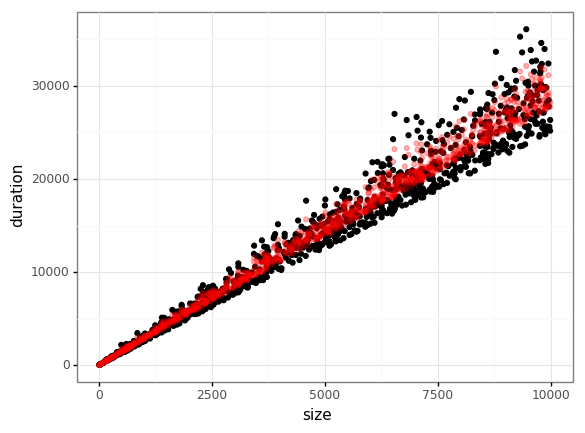

<ggplot: (8775801107015)>

In [4]:
plot + geom_point(data=generate_dataset(*params), color='red', alpha=0.3)

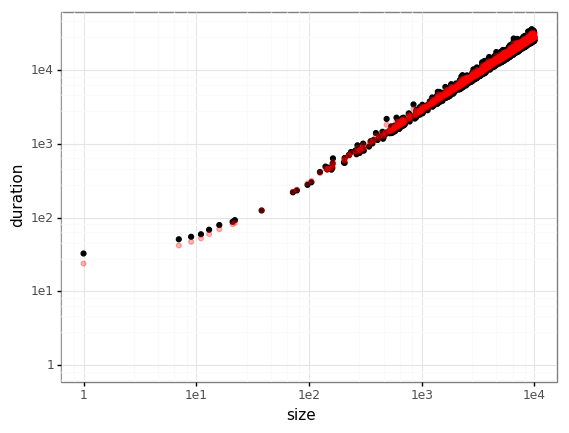

<ggplot: (8775738747919)>

In [5]:
plot + geom_point(data=generate_dataset(*params), color='red', alpha=0.3) + scale_x_log10() + scale_y_log10()

## Linear regression approach

In [6]:
def compute_params_lm(df, quantile=0.01):
    reg = st.ols(data=df, formula='duration ~ size').fit()
    coefficient = reg.params.size
    intercept = reg.params.Intercept
    norm_residuals = reg.resid / df['size']
    sigma = norm_residuals.std()
    return intercept, coefficient, sigma

params = compute_params_lm(df)
params

(46.93494233106144, 2, 0.6285753168446309)

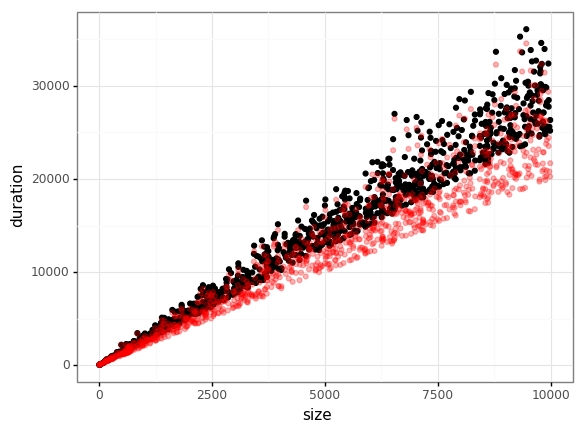

<ggplot: (8775738763710)>

In [7]:
plot + geom_point(data=generate_dataset(*params), color='red', alpha=0.3)

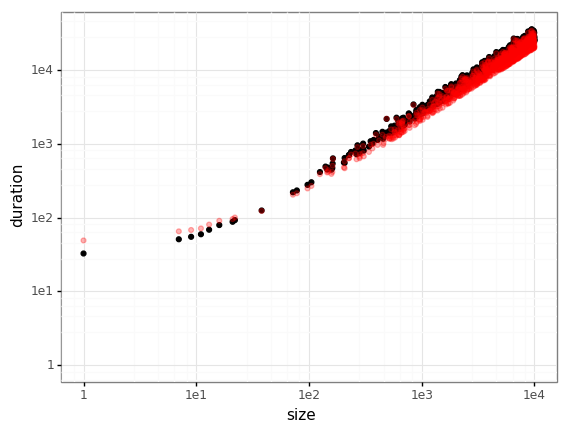

<ggplot: (8775738623713)>

In [8]:
plot + geom_point(data=generate_dataset(*params), color='red', alpha=0.3) + scale_x_log10() + scale_y_log10()

## Bayesian approach

In [9]:
%%time

model_code = """
data {
    int<lower=1> N; // number of points
    vector[N] X; // real X[N] does not work
    vector[N] Y;
}
parameters {
    real alpha;
    real beta;
    real sigma;
}
model {
    alpha ~ normal(0, 20);
    beta ~ normal(0, 20); 
    sigma ~ normal(1, 1);
    Y ~ normal(alpha + X*beta, sigma);
}
"""

sm = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e3399037d2cfff6f6d86586f00ecb37d NOW.


CPU times: user 1.04 s, sys: 44.1 ms, total: 1.09 s
Wall time: 1min 3s


Inference for Stan model: anon_model_e3399037d2cfff6f6d86586f00ecb37d.
8 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha  21.77    6.08  16.07  -1.51   2.91  23.94   34.6   48.9      7   1.68
beta    2.89  9.1e-4 2.7e-3   2.89   2.89   2.89   2.89   2.89      9   1.42
sigma 231.74    0.01   0.52 230.72 231.37 231.73 232.09 232.79   1884    1.0
lp__  -5.9e4    0.65   1.78 -5.9e4 -5.9e4 -5.9e4 -5.9e4 -5.9e4      7   1.52

Samples were drawn using NUTS at Thu Jan 31 16:28:39 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
CPU times: user 132 ms, sys: 47.9 ms, total: 179 ms
Wall time: 9.1 s


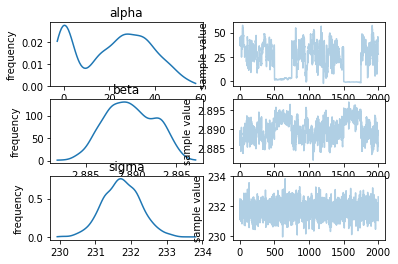

In [10]:
%%time

data=dict(N=len(df), Y=df['duration'], X=df['size'])

fit = sm.sampling(data=data, iter=500, chains=8)

print(fit)

fit.plot()

In [11]:
%%time

model_code = """
data {
    int<lower=1> N; // number of points
    vector[N] X; // real X[N] does not work
    vector[N] Y;
}
parameters {
    real alpha;
    real beta;
    real sigma;
}
model {
    alpha ~ normal(0, 20);
    beta ~ normal(0, 20); 
    sigma ~ normal(1, 1);
    Y ~ normal(alpha + X*beta, sigma*X);
}
"""

sm = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_81735d05a4eb93e0d77a79faf1d7a296 NOW.


CPU times: user 993 ms, sys: 104 ms, total: 1.1 s
Wall time: 55 s


Inference for Stan model: anon_model_81735d05a4eb93e0d77a79faf1d7a296.
8 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha  29.85  6.9e-3   0.29  29.28  29.65  29.85  30.06  30.43   1796    1.0
beta    2.89  3.9e-4 8.9e-3   2.87   2.88   2.89    2.9   2.91    532   1.02
sigma    0.3  1.5e-4 6.5e-3   0.28   0.29    0.3    0.3   0.31   1968    1.0
lp__   -7477    0.04   1.17  -7480  -7478  -7477  -7476  -7476    809    1.0

Samples were drawn using NUTS at Thu Jan 31 16:29:35 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
CPU times: user 117 ms, sys: 61.5 ms, total: 178 ms
Wall time: 984 ms


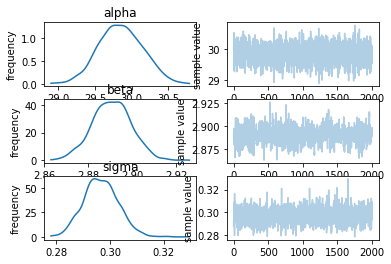

In [12]:
%%time

data=dict(N=len(df), Y=df['duration'], X=df['size'])

fit = sm.sampling(data=data, iter=500, chains=8)

print(fit)

fit.plot()

In [13]:
%%time

model_code = """
data {
    int<lower=1> N; // number of points
    vector<lower=0>[N] X; // real X[N] does not work
    vector<lower=0>[N] Y;
}
parameters {
    real<lower=0> alpha;
    real<lower=0> beta;
    real<lower=0> sigma;
}
model {
    alpha ~ normal(0, 20);
    beta ~ normal(0, 20); 
    sigma ~ normal(1, 1);
    Y ~ normal(alpha + X*beta, sigma*X);
}
"""

sm = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5514e8fa74607ab5c64ce19f22cde812 NOW.


CPU times: user 917 ms, sys: 142 ms, total: 1.06 s
Wall time: 55.3 s


Inference for Stan model: anon_model_5514e8fa74607ab5c64ce19f22cde812.
8 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha  29.86  7.7e-3   0.29   29.3  29.67  29.86  30.06  30.42   1379    1.0
beta    2.89  1.9e-4 9.4e-3   2.87   2.88   2.89    2.9   2.91   2545    1.0
sigma    0.3  1.8e-4 6.6e-3   0.28   0.29    0.3    0.3   0.31   1382    1.0
lp__   -7474    0.04   1.22  -7477  -7474  -7474  -7473  -7473    951    1.0

Samples were drawn using NUTS at Thu Jan 31 16:30:32 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
CPU times: user 194 ms, sys: 62.2 ms, total: 256 ms
Wall time: 1.05 s


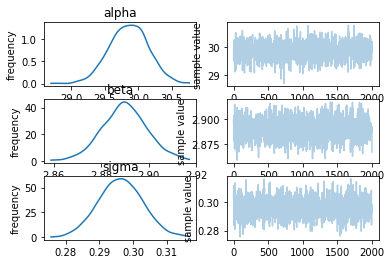

In [14]:
%%time

data=dict(N=len(df), Y=df['duration'], X=df['size'])

fit = sm.sampling(data=data, iter=500, chains=8)

print(fit)

fit.plot()

In [15]:
def get_generated_data(fit):
    fit = fit.extract()
    alpha = fit['alpha'].mean()
    beta  = fit['beta'].mean()
    sigma = fit['sigma'].mean()
    return alpha, beta, sigma

params = get_generated_data(fit)
params

(29.85989951502736, 2.8899777561084874, 0.2963398590623856)

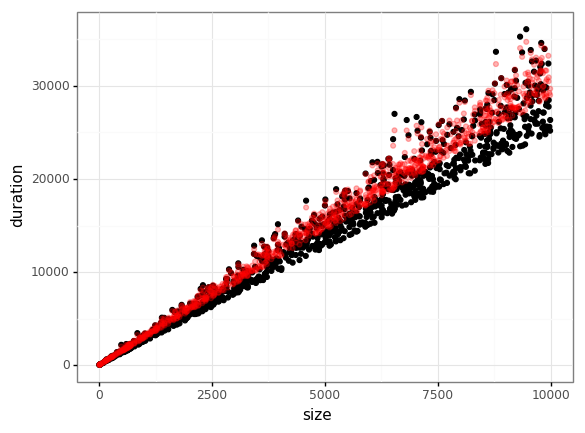

<ggplot: (-9223363261150016014)>

In [16]:
plot + geom_point(data=generate_dataset(*params), color='red', alpha=0.3)

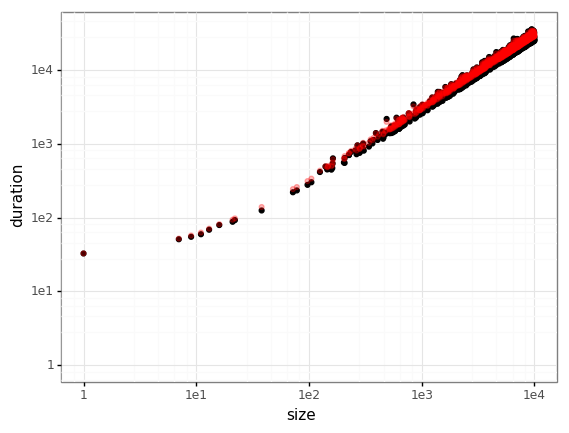

<ggplot: (8775704770750)>

In [17]:
plot + geom_point(data=generate_dataset(*params), color='red', alpha=0.3) + scale_x_log10() + scale_y_log10()

In [18]:
%%time

model_code = """
data {
    int<lower=1> N; // number of points
    vector<lower=0>[N] X; // real X[N] does not work
    vector<lower=0>[N] Y;
}
parameters {
    real<lower=0> alpha;
    real<lower=0> beta;
    real<lower=0> sigma;
}
model {
    alpha ~ normal(0, 20);
    beta ~ normal(0, 20); 
    sigma ~ normal(1, 1);
    for (i in 1:N) {
        target += abs(normal_lpdf(Y[i] | alpha + X[i]*beta, sigma*X[i])); // https://stackoverflow.com/questions/40289457/stan-using-target-syntax
    }
}
"""

sm = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_d27a95961888ebb3b994b72c0d465eb8 NOW.


CPU times: user 847 ms, sys: 47.8 ms, total: 895 ms
Wall time: 57.6 s


Inference for Stan model: anon_model_d27a95961888ebb3b994b72c0d465eb8.
8 chains, each with iter=500; warmup=250; thin=1; 
post-warmup draws per chain=250, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha   2.27    0.87   1.74   0.32   1.47   1.66   2.65   6.42      4 8692.0
beta   26.59   21.33  43.42   0.21   0.57   0.91  42.78 126.18      4  12.56
sigma   3.15    2.49    5.0   0.14    0.2   0.26   5.73  12.99      4  30.99
lp__   7.4e4   1.3e4  3.4e4  3.0e4  5.1e4  6.5e4  8.9e4  1.8e5      7   3.66

Samples were drawn using NUTS at Thu Jan 31 16:31:32 2019.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).
CPU times: user 138 ms, sys: 79.6 ms, total: 217 ms
Wall time: 807 ms


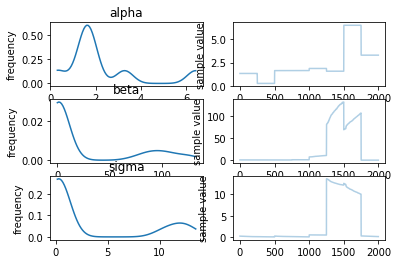

In [19]:
%%time

data=dict(N=len(df), Y=df['duration'], X=df['size'])

fit = sm.sampling(data=data, iter=500, chains=8)

print(fit)

fit.plot()

In [20]:
params = get_generated_data(fit)
params

(2.2734743000824844, 26.593388179652614, 3.1455111783195724)